สร้าง Class Dataset และ DataLoader จัดการเรื่องป้อนข้อมูลตัวอย่างให้ Neural Network ทีละ Mini-batch โดย[เริ่มต้น Refactor ที่หัวข้อ 6](#6.-Refactor-ส่วน-x,-y)

# 0. Magic

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import

In [2]:
import torch
from torch import tensor
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch
import operator

# 2. Data

In [3]:
MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

In [4]:
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train, y_train, x_valid, y_valid))

In [5]:
x_train, y_train, x_valid, y_valid = get_data()

# 3. เตรียม Data

In [6]:
# x = data, m = mean, s = standard deviation
def normalize(x, m, s): 
    return (x-m)/s

In [7]:
train_mean, train_std = x_train.mean(), x_train.std()
x_train = normalize(x_train, train_mean, train_std)
x_valid = normalize(x_valid, train_mean, train_std)

In [8]:
n, m = x_train.shape
c = y_train.max()+1
n, m, c

(50000, 784, tensor(10))

# 4. สร้าง Model

โมเดลจะประกอบด้วยส่วนต่าง ๆ เช่น Architecture กำหนด Layers ต่าง ๆ, Initialization, Loss Function, อัลกอริทึมในการเทรน และ Metrics ที่เราเรียนรู้กันไปใน ep ก่อน ๆ 

โมเดล

In [9]:
class Model(nn.Module):
    # number of input feature, number of hidden feature, number of output feature
    def __init__(self, n_in, nh, n_out):
        super().__init__()
#         set_trace()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]        
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

เคสนี้เป็นงาน Classification เราจะใช้ [Cross Entropy Loss Fucntion](https://www.bualabs.com/wp-admin/post.php?post=1945&action=edit)

In [10]:
def get_model():
    # loss function
    loss_func = F.cross_entropy
    model = Model(m, nh, c.numpy())
    return model, loss_func

ในเคสนี้เราจะใช้ [metrics เป็น Accuracy](https://www.bualabs.com/archives/1968/what-is-metrics-confusion-matrix-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) ประกาศฟังก์ชัน accuracy 

In [11]:
def accuracy(yhat, y):
    return (torch.argmax(yhat, dim=-1) == y).float().mean()

กำหนด Hyperparameter

In [12]:
# batch size
bs = 64
# learning rate
lr = 0.03
epoch = 1
nh = 50

In [13]:
model, loss_func = get_model()
losses, metrics = [], []

# 5. Training Loop

เราจะเทรนโมเดล ด้วยอัลกอริทึม [Stochastic Gradient Descent (SGD)](https://www.bualabs.com/wp-admin/post.php?post=631&action=edit) และ เก็บ Loss, Accuracy เอาไว้พล็อตกราฟ

ประกาศฟังก์ชัน fit เอาไว้เรียกเทรนเวลาที่ต้องการ

In [14]:
def fit():
    losses, metrics = [], []
    # e = epoch number
    for e in range(epoch):
        # b = batch number
        for b in range((n-1)//bs + 1):

            # data
            start_b = b*bs
            end_b = start_b+bs
            xb, yb = x_train[start_b:end_b], y_train[start_b:end_b]

            # Feedforward
            yhatb = model(xb)
            loss = loss_func(yhatb, yb)

            # Metrics
            acc = accuracy(yhatb, yb)
            losses.append(loss); metrics.append(acc)            

            # Backpropagation
            loss.backward()

            # Update Wight and Bias with SGD
            with torch.no_grad():
                for l in model.layers:
                    if hasattr(l, 'weight'):
                        l.weight -= l.weight.grad * lr
                        l.bias   -= l.bias.grad * lr 
                        l.weight.grad.zero_()
                        l.bias.grad.zero_()       
                        
    plot_metrics(losses, metrics)

ประการฟัง์ชัน ไว้พล็อตกราฟ Loss และ Accuracy

In [15]:
def plot_metrics(losses, metrics):
    x = torch.arange(len(losses)).numpy()
    fig,ax = plt.subplots(figsize=(9, 9))
    ax.grid(True)
    ax.plot(x, losses, label="Loss")
    ax.plot(x, metrics, label="Accuracy")
    ax.legend(loc='upper right')

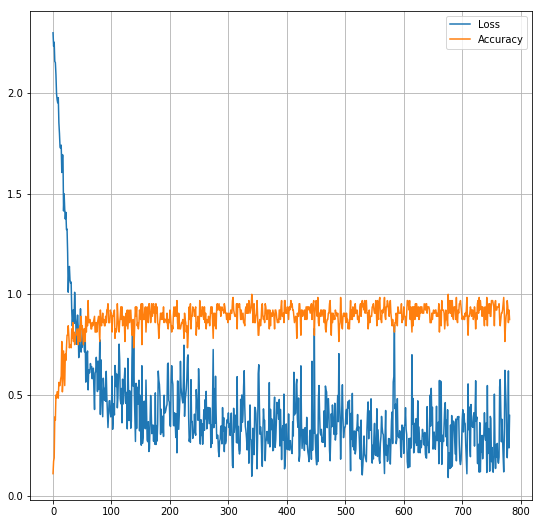

In [16]:
model, loss_func = get_model()
fit()

# 6. Refactor ส่วน x, y

x และ y ใช้คู่กัน เราจะสร้าง Class Dataset ขึ้นมาห่อไว้

In [17]:
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [18]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [19]:
xb, yb = train_ds[0:100]
xb.shape, yb.shape

(torch.Size([100, 784]), torch.Size([100]))

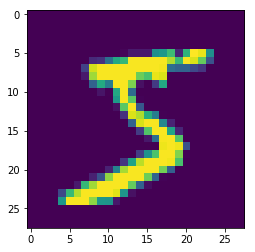

In [20]:
plt.imshow(xb[0].view(28,28))

Training Loop เวอร์ชัน 2 เปลี่ยนมาใช้ Dataset

In [21]:
def fit2():
    losses, metrics = [], []
    # e = epoch number
    for e in range(epoch):
        # b = batch number
        for b in range((n-1)//bs + 1):

            # data
            start_b = b*bs
            end_b = start_b+bs            
            xb, yb = train_ds[start_b:end_b]

            # Feedforward
            yhatb = model(xb)
            loss = loss_func(yhatb, yb)

            # Metrics
            acc = accuracy(yhatb, yb)
            losses.append(loss); metrics.append(acc)

            # Backpropagation
            loss.backward()

            # Update Wight and Bias with SGD
            with torch.no_grad():
                for l in model.layers:
                    if hasattr(l, 'weight'):
                        l.weight -= l.weight.grad * lr
                        l.bias   -= l.bias.grad * lr 
                        l.weight.grad.zero_()
                        l.bias.grad.zero_()      
                        
    plot_metrics(losses, metrics)

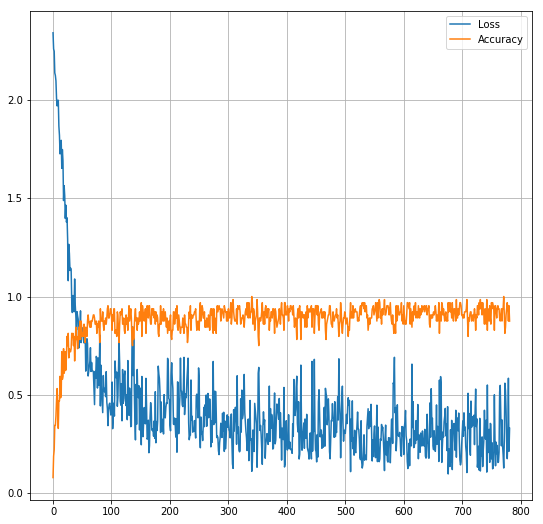

In [22]:
model, loss_func = get_model()
fit2()

# 7. Refactor ส่วน Batch

In [23]:
class DataLoader():
    # ds = Dataset, bs = batch size
    def __init__(self, ds, bs):
        self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

In [24]:
train_dl, valid_dl = DataLoader(train_ds, bs), DataLoader(valid_ds, bs)

เราสามารถ Iterate ไป Batch ต่อ ๆ ไปได้ ด้วยฟังก์ชัน next โดยไม่เปลือง Memory เพราะ yield เป็น Lazy Loading จะโหลดเท่าที่จำเป็นเท่านั้น ไม่ใช่โหลดทั้ง Dataset

In [25]:
train_iter = iter(train_dl)

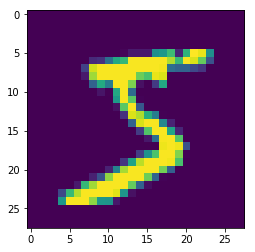

In [26]:
xb, yb = next(train_iter)
plt.imshow(xb[0].view(28,28))

แสดง x ที่ตำแหน่ง 0 ของ Batch ถัดมา

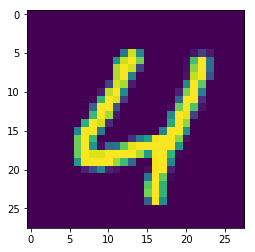

In [27]:
xb, yb = next(train_iter)
plt.imshow(xb[0].view(28,28))

Training Loop เวอร์ชัน 3 เปลี่ยนมาใช้ DataLoader ข้อดี คือ เราไม่ต้องจัดการ Index เอง

In [28]:
def fit3():
    losses, metrics = [], []
    # e = epoch number
    for e in range(epoch):
        for xb, yb in train_dl:

            # Feedforward
            yhatb = model(xb)
            loss = loss_func(yhatb, yb)

            # Metrics
            acc = accuracy(yhatb, yb)
            losses.append(loss); metrics.append(acc)

            # Backpropagation
            loss.backward()

            # Update Wight and Bias with SGD
            with torch.no_grad():
                for l in model.layers:
                    if hasattr(l, 'weight'):
                        l.weight -= l.weight.grad * lr
                        l.bias   -= l.bias.grad * lr 
                        l.weight.grad.zero_()
                        l.bias.grad.zero_()       

    plot_metrics(losses, metrics)

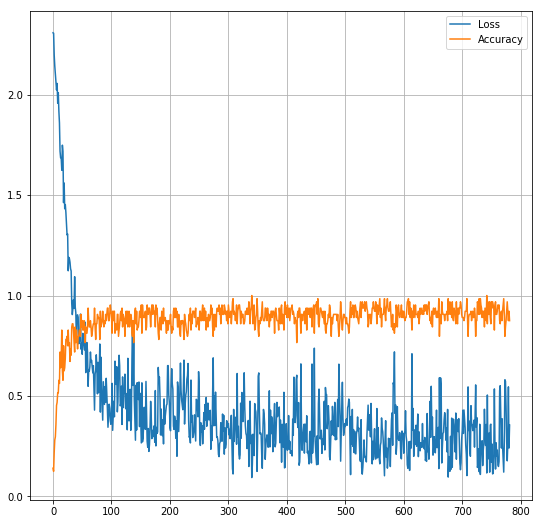

In [29]:
model, loss_func = get_model()
fit3()

# 8. สรุป

1. เราได้ Refactor โค้ด Training Loop ในส่วน Data ให้คลีนมากขึ้น เป็น Class ชื่อ Dataset และ DataLoader
1. Dataset ช่วย Encapsulate x, y ไว้ด้วยกัน
1. DataLoader จัดการ Batch ของ Dataset ทำให้เราไม่ต้องจัดการ Index, Batch Size เอง และช่วยในเรื่อง Lazy Loading ด้วย

# Credit 

* https://course.fast.ai/videos/?lesson=9
* https://pytorch.org/docs/stable/data.html